In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data 

In [4]:
! {sys.executable} -m pip install kaggle --upgrade

     |████████████████████████████████| 61kB 763kB/s eta 0:00:01
     |████████████████████████████████| 81kB 1.5MB/s eta 0:00:011
  Created wheel for kaggle: filename=kaggle-1.5.5-cp37-none-any.whl size=71897 sha256=35d04d9b4cfd598d9ecca77d869bc5dad8a8d86140143b9109261be42b9db03e
  Stored in directory: /home/ricky/.cache/pip/wheels/db/6a/80/6cd1892eb9b9b136333db3c74e16cba4e17e2c700f51541f06
  Created wheel for python-slugify: filename=python_slugify-3.0.3-py2.py3-none-any.whl size=4786 sha256=31bf0ae4117d93fc08c79832793f90f048f3edffe90b6889b7f25ca2508f8003
  Stored in directory: /home/ricky/.cache/pip/wheels/0f/96/ca/85f5b01165975402d1e37f8dd346df00dc39be1d0761bd17bb
Successfully built kaggle python-slugify


In [5]:
sys.executable

'/home/ricky/anaconda2/envs/deeplearning/bin/python'

In [5]:
path = Path("/home/ricky/Desktop/repos/fastai_course/data")/"planet"
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/ricky/Desktop/repos/fastai_course/data/planet')

In [12]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}

100%|███████████████████████████████████████▉| 600M/600M [07:47<00:00, 1.67MB/s]
100%|████████████████████████████████████████| 600M/600M [07:47<00:00, 1.35MB/s]


In [14]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  

100%|█████████████████████████████████████████| 159k/159k [00:00<00:00, 883kB/s]



In [15]:
! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [17]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Multiclassification

In [6]:
df = pd.read_csv(path/"train_v2.csv")
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0)

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(path, "train_v2.csv", folder="train-jpg", suffix=".jpg")
      .split_by_rand_pct(0.2)
      .label_from_df(label_delim=' '))

In [9]:
type(src)

fastai.data_block.LabelLists

In [10]:
data = (src.transform(tfms, size=128)
       .databunch().normalize(imagenet_stats))

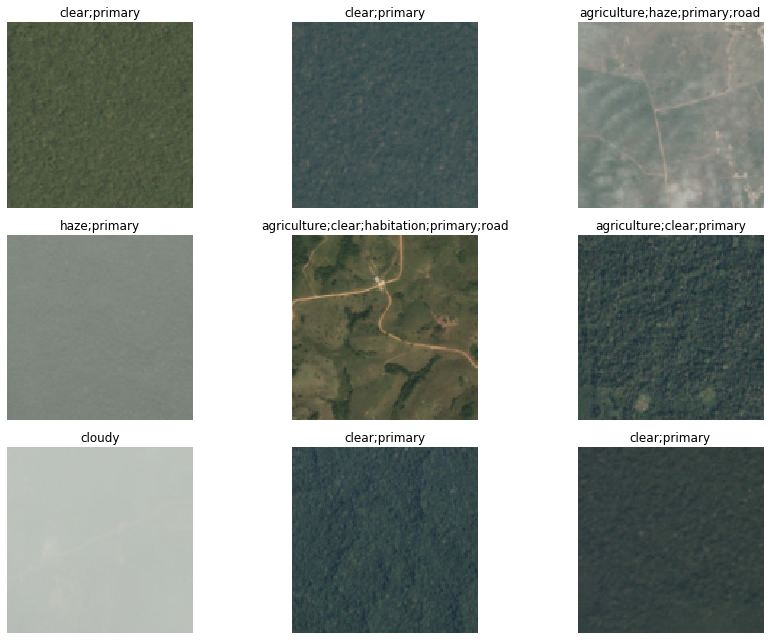

In [11]:
data.show_batch(rows=3, figsize=(12,9))

In [12]:
data

ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/ricky/Desktop/repos/fastai_course/data/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/ricky/Desktop/repos/fastai_course/data/planet;

Test: None

In [13]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [14]:
data.c

17

In [15]:
arch = models.resnet50

here we are using the partial function to make a custom function 

In [16]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


use the stepest value but not the bottom

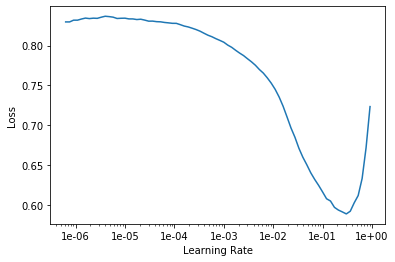

In [34]:
learn.recorder.plot()

In [38]:
lr = 0.01

In [39]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.127649,0.110448,0.945755,0.903578,02:00
1,0.109224,0.100039,0.953748,0.913064,02:01
2,0.102980,0.091950,0.956400,0.919531,02:01
3,0.095118,0.088417,0.955622,0.921313,02:01
4,0.090869,0.087118,0.956524,0.925941,02:01


In [40]:
learn.save('stage-1-rn50')

In [41]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


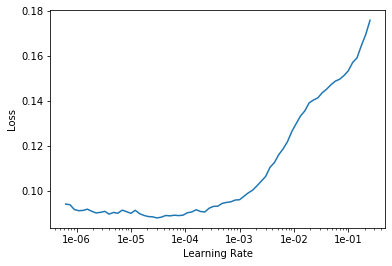

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095419,0.091695,0.954845,0.920569,02:34
1,0.096888,0.088508,0.953682,0.922736,02:36
2,0.090901,0.085286,0.958602,0.926856,02:36
3,0.085473,0.083915,0.958544,0.926793,02:37
4,0.079918,0.082952,0.957599,0.927805,02:37


In [44]:
learn.save('stage-2-rn50')

In [17]:
learn.load('stage-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /home/ricky/Desktop/repos/fastai_course/data/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /home/ricky/Desktop/repos/fastai_course/data/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace

In [20]:
data = (src.transform(tfms, size=256)
       .databunch(bs=16).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [21]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


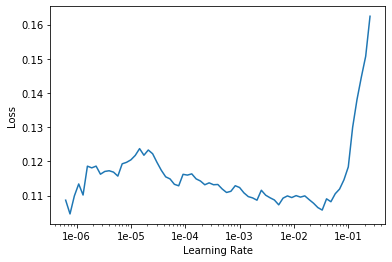

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr = 1e-2/2

In [24]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.094318,0.094172,0.961188,0.920931,07:21
1,0.101168,0.093353,0.963012,0.920699,07:22
2,0.091456,0.089710,0.959059,0.921247,07:23
3,0.093654,0.086110,0.957824,0.925372,07:23
4,0.086495,0.087002,0.959278,0.925891,07:23


In [25]:
learn.save("stage-1-256-rn50")

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095630,0.089197,0.956480,0.921735,09:41
1,0.090570,0.103159,0.958660,0.923663,09:42
2,0.095432,0.194362,0.959583,0.923565,09:43
3,0.085070,0.098043,0.960222,0.928210,09:44
4,0.083597,0.169444,0.959089,0.927143,09:44


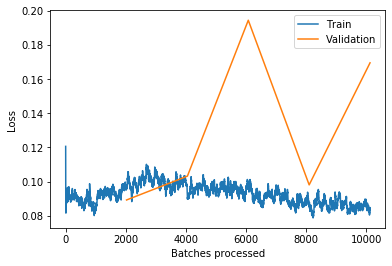

In [28]:
learn.recorder.plot_losses()

In [29]:
learn.save("stage-2-256-rn5")

In [30]:
learn.export()

## Image segmentation with CamVid

In [3]:
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
??untar_data

In [5]:
path = untar_data(URLs.CAMVID, dest="data")
path.ls()

[PosixPath('data/camvid/valid.txt'),
 PosixPath('data/camvid/labels'),
 PosixPath('data/camvid/codes.txt'),
 PosixPath('data/camvid/images')]

In [6]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [7]:
path_img

PosixPath('data/camvid/images')

In [9]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/camvid/images/0006R0_f00930.png'),
 PosixPath('data/camvid/images/0016E5_08065.png'),
 PosixPath('data/camvid/images/0016E5_02040.png')]

In [10]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/camvid/labels/0016E5_08073_P.png'),
 PosixPath('data/camvid/labels/0016E5_08059_P.png'),
 PosixPath('data/camvid/labels/0001TP_008460_P.png')]

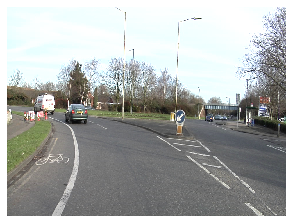

In [11]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [15]:
img_f.stem, img_f.suffix

('0006R0_f00930', '.png')

In [16]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

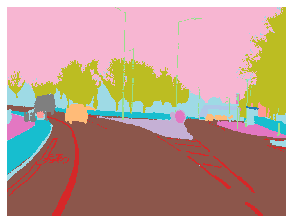

In [17]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)

In [18]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [20]:
codes = np.loadtxt(path/"codes.txt", dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets 

In [21]:
size = src_size//2 # reduce images by a factor of two
free = gpu_mem_get_free_no_cache()

if free > 8200: bs = 8
else:           bs = 4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 5683MB of GPU RAM free


In [22]:
path_img

PosixPath('data/camvid/images')

In [23]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [24]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

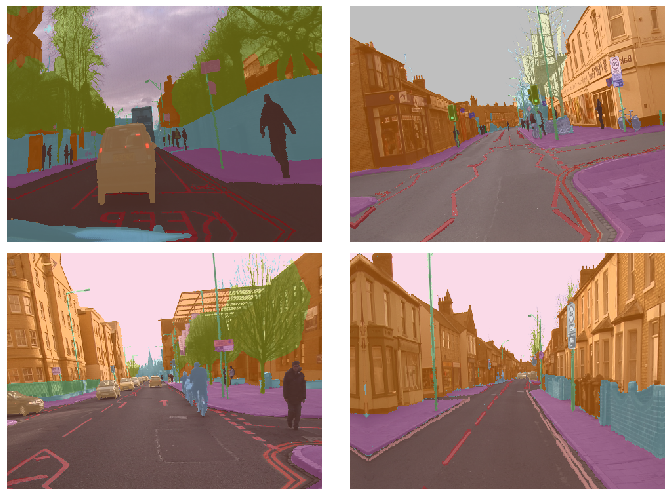

In [25]:
data.show_batch(2, figsize=(10, 7))

## Model 

In [26]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id["Void"]

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [28]:
void_code

30

In [29]:
metrics = acc_camvid

In [30]:
wd = 1e-2

In [31]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


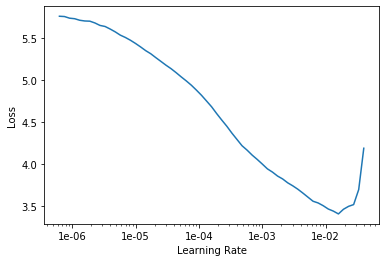

In [32]:
lr_find(learn)
learn.recorder.plot()

In [33]:
doc(unet_learner)

In [34]:
lr = 3e-3

In [35]:
doc(learn.fit_one_cycle)

In [36]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.958963,0.793070,0.810806,01:45
1,0.724105,0.642354,0.846599,01:45
2,0.636431,0.487876,0.874555,01:45
3,0.628240,0.432881,0.885237,01:45
4,0.626613,0.500493,0.878304,01:45
5,0.611250,0.518145,0.863960,01:45
6,0.550321,0.450244,0.876440,01:45
7,0.514239,0.437043,0.874870,01:45
8,0.533817,0.374261,0.894420,01:45
9,0.411068,0.309066,0.909761,01:45


In [37]:
learn.save("stage-1")

In [38]:
learn.load('stage-1');

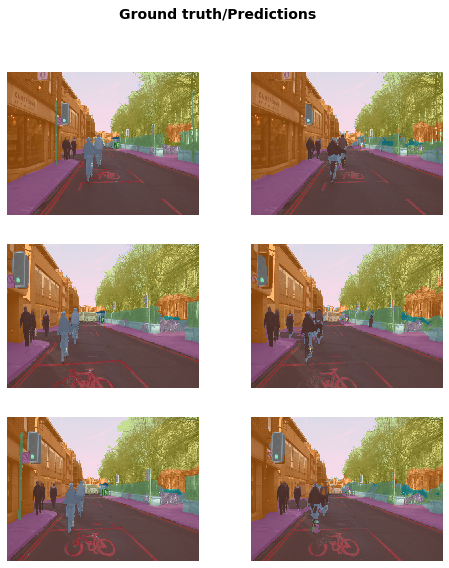

In [39]:
learn.show_results(rows=3, figsize=(8,9))

In [40]:
learn.unfreeze()

In [41]:
lrs = slice(lr/400, lr/4)

In [42]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.376214,0.299013,0.913230,01:50
1,0.372700,0.301596,0.911270,01:50
2,0.357239,0.299357,0.911815,01:49
3,0.354214,0.302774,0.910161,01:51
4,0.337830,0.280157,0.918183,01:51
5,0.337543,0.298960,0.913678,01:51
6,0.323275,0.285012,0.919381,01:51
7,0.331439,0.294339,0.918583,01:51
8,0.328831,0.304969,0.911571,01:51
9,0.309018,0.283783,0.916253,01:51


In [43]:
learn.save('stage-2')

## Go big

In [45]:
learn.destroy()
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 5220MB of GPU RAM free


In [46]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [47]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [48]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


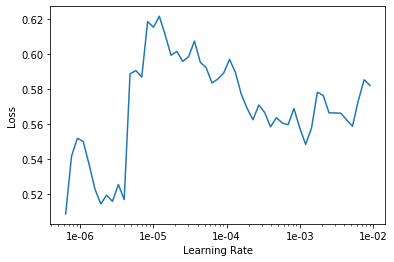

In [49]:
lr_find(learn)
learn.recorder.plot()

In [50]:
lr=1e-3

In [51]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.385007,0.311896,0.911300,06:56
1,0.358762,0.293251,0.915767,06:41
2,0.376093,0.299025,0.913072,06:38
3,0.338735,0.305008,0.918820,06:38
4,0.360472,0.315987,0.914602,06:39
5,0.327626,0.294623,0.918011,06:39
6,0.373523,0.318558,0.914032,06:39
7,0.338636,0.311460,0.916858,06:39
8,0.337091,0.295489,0.920455,06:39
9,0.232886,0.262979,0.930396,06:39


In [52]:
learn.save('stage-1-big')

In [53]:
learn.load('stage-1-big');

In [54]:
learn.unfreeze()

In [55]:
lrs = slice(1e-6,lr/10)

In [56]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.225446,0.265350,0.930952,07:49
1,0.242786,0.258239,0.929962,07:49
2,0.204626,0.260812,0.930900,07:49
3,0.238013,0.263674,0.929985,07:49
4,0.202890,0.263856,0.931083,07:50
5,0.212738,0.267213,0.932028,07:49
6,0.213959,0.261442,0.931844,07:50
7,0.212450,0.269428,0.930071,07:50
8,0.192514,0.257734,0.932847,07:49
9,0.194005,0.259400,0.933533,07:49


In [57]:
learn.save('stage-2-big')

In [58]:
learn.load('stage-2-big');

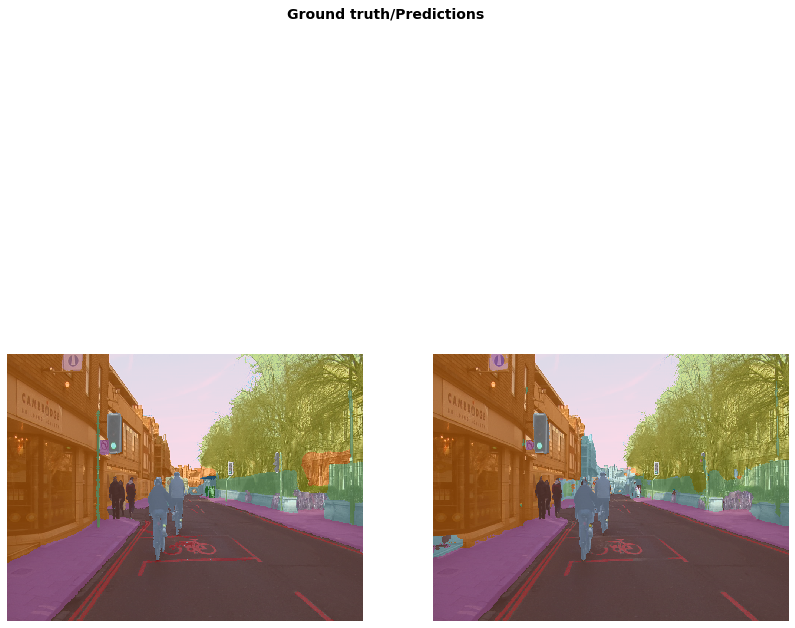

In [60]:
learn.show_results(rows=3, figsize=(14,14))

In [62]:
for cl in data.classes:
    print(cl)

Animal
Archway
Bicyclist
Bridge
Building
Car
CartLuggagePram
Child
Column_Pole
Fence
LaneMkgsDriv
LaneMkgsNonDriv
Misc_Text
MotorcycleScooter
OtherMoving
ParkingBlock
Pedestrian
Road
RoadShoulder
Sidewalk
SignSymbol
Sky
SUVPickupTruck
TrafficCone
TrafficLight
Train
Tree
Truck_Bus
Tunnel
VegetationMisc
Void
Wall
